# nonlinear likelihoods & calibration kernels

- verifying the intuition that SNPE fits will tend to be more global than CDELFI 
- exploring usage of calibration kernels to control this behavior

## background

- core DELFI loss derives from fitting MDN $q_\phi(\theta|x)$ to joint density $p(\theta,x)$
$$ \mathcal{L}(\phi) = D_{KL}( p(\theta) p(x | \theta) || q_\phi(\theta|x) p(x)) + const. $$
defined by prior $p(\theta)$ and simulator $p(x | \theta)$.

$\hspace{0.1cm}$

- CDELFI (Papamakarios et al.) introduces proposals $\tilde{p}(\theta)$ and fits the MDN to modified loss
$$ \tilde{\mathcal{L}}(\phi)  = D_{KL}( p(\theta) p(x | \theta) || q_\phi(\theta|x) p(x)) + const. $$
with subsequent analytic correction of wrong posterior $ q_\phi(\theta | x_0) \approx \tilde{p}(\theta | x_0 ) $ at observed data $x_0$.

$\hspace{0.1cm}$

- SNPE introduces importance weighting to avoid analytic correction and get back to $\mathcal{L}(\phi)$ through
$$ \mathcal{L}(\phi)  = D_{KL}( \tilde{p}(\theta) \frac{p(\theta)}{ \tilde{p}(\theta)} p(x | \theta) || q_\phi(\theta|x) p(x)) + const. $$


- globally minimizing $D_{KL}( \tilde{p}(\theta) \frac{p(\theta)}{ \tilde{p}(\theta)} p(x | \theta) || q_\phi(\theta|x) p(x))$ may become a problem when the approximator $q_\phi(\theta|x)$ is less complex than the actual $p(\theta | x)$.
- in part, that's what the proposal $\tilde{p}(\theta)$ was originally introduced for: to locally approximate  $p(\theta | x)$ around $x = x_0$.
- empirical observation: fits with same network size appear poorer for SNPE than CDELFI (mapRF subproject) even for very large data-sets ($N \geq 50k$).

## question

- **does SNPE still support the focusing feature of the proposal?**


## approach

- run SNPE and CDELFI on linear and **non-linear** toy problems with **narrow** ground-truth posteriors. 
- provide proposal priors that match the actual posterior for different data points $x_0$, i.e. $\tilde{p}(\theta) \approx p(\theta | x_0 )$, and fit with **linear** MDNs.
- known problem for SNPE: importance sampling breaks, hence try **Student-t proposals for SNPE**. 

In [7]:
%%capture 
import util
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds
from delfi.simulator.Gauss import Gauss

## problem setup ##

n_params = 1

assert n_params == 1 # cannot be overstressed: everything in this notebook goes downhill sharply otherwise


def my_fun(df, x0s, proposal_form, model, eta2, sig2, N):        

    plt.figure(figsize=(12,5))
    
    seed = 41
    s = ds.Identity()
    p = dd.Gaussian(m=0. * np.ones(n_params), 
                    S=eta2 * np.eye(n_params))    
    if model=='lin':
        m = Gauss(dim=n_params, noise_cov=sig2, seed=seed)
    elif model=='log':
        m = util.LogGauss(dim=n_params, noise_cov=sig2, seed=seed)   
    g = dg.Default(model=m, prior=p, summary=s)
    data = g.gen(1000, verbose=False)
    params, stats = data[0].reshape(-1), data[1].reshape(-1)
    plt.subplot(1,2,1)
    plt.plot( 0, 0, 'r', linewidth=2.)
    plt.plot( 0, 0, 'g', linewidth=2.)
    plt.legend(['CDELFI', 'SNPE'], loc=2, frameon=False)
    plt.plot( stats, params, 'o' )        
    
    for idx0 in range(len(x0s)):

        x0 = np.array([x0s[idx0]])
        sig2_true = 1./(1/eta2+1/sig2)
        if model=='lin':
            mu_true   = (x0/sig2)*sig2_true
        elif model=='log':
            mu_true   = (np.log(x0)/sig2)*sig2_true

        ksi2 = sig2_true
        nu = mu_true

        # 'fit CDELFI MDN

        ppr = dd.Gaussian(m=nu * np.ones(n_params), 
                         S=ksi2 * np.eye(n_params),
                         seed=seed)
        g = dg.Default(model=m, prior=ppr, summary=s)
        # gen data
        data = g.gen(N, verbose=False)
        params, stats = data[0].reshape(-1), data[1].reshape(-1)

        ahat_CDELFI =       util.alpha(params, stats, np.ones(N)/N)
        bhat_CDELFI =        util.beta(params, stats, np.ones(N)/N, ahat_CDELFI)
        gamma2hat_CDELFI = util.gamma2(params, stats, np.ones(N)/N, ahat_CDELFI, bhat_CDELFI)

        mu_hat_CDELFI   = ahat_CDELFI + bhat_CDELFI * x0
        sig2_hat_CDELFI = gamma2hat_CDELFI

        # 'fit' SNPE MDN
        a,b=None,None
        if proposal_form == 'normal':
            ppr = dd.Gaussian(m=nu * np.ones(n_params), 
                             S=ksi2 * np.eye(n_params),
                             seed=seed)
        elif proposal_form == 'studentT':
            ppr = dd.StudentsT(m=nu * np.ones(n_params), 
                               S=ksi2 * np.eye(n_params), # * (df-2.)/df,
                               dof=df,
                               seed=seed)    
        elif proposal_form == 'unif':
            a = nu - marg/2. * np.sqrt(ksi2)
            b = nu + marg/2. * np.sqrt(ksi2)
            ppr = dd.Uniform(lower=a, upper=b, seed=seed)
        else:
            raise NotImplementedError
        g = dg.Default(model=m, prior=ppr, summary=s)
        # gen data
        data = g.gen(N, verbose=False)
        params, stats = data[0].reshape(-1), data[1].reshape(-1)

        normals = util.get_weights(proposal_form, eta2, ksi2, 1e20, x0, nu, stats, params, df=df, a=a,b=b) 
        ahat_SNPE =       util.alpha(params, stats, normals)
        bhat_SNPE =        util.beta(params, stats, normals, ahat_SNPE)
        gamma2hat_SNPE = util.gamma2(params, stats, normals, ahat_SNPE, bhat_SNPE)


        out_ = util.analytic_div(np.array((mu_hat_CDELFI, sig2_hat_CDELFI)).reshape(1,1,2), 
                          eta2, nu*np.ones(1), ksi2*np.ones(1))

        #print('target posterior \n', (mu_true, sig2_true))
        #print('SNPE posterior \n', (ahat_SNPE + x0 * bhat_SNPE, gamma2hat_SNPE))
        #print('CDELFI posterior (raw) \n', (mu_hat_CDELFI, gamma2hat_CDELFI))
        #print('CDELFI posterior (corrected) \n', (out_[0,0,0], out_[0,0,1]))

        plt.subplot(1,2,1)
        
        if model=='log':
            x = np.array([0,9])
            y = [-1,3.5]
        elif model=='lin':
            x = np.array([-3,3])            
            y = [-3, 3]
        f = ahat_SNPE + bhat_SNPE*x
        sig = np.sqrt(gamma2hat_SNPE)
        plt.plot( x, f, 'g', linewidth=2)
        plt.fill_between(x, f-sig,f+sig, 
                         where=None, facecolor='g', alpha=0.3)
        f = ahat_CDELFI + bhat_CDELFI*x
        sig = np.sqrt(gamma2hat_CDELFI)
        plt.plot( x, f, 'r', linewidth=2)
        plt.fill_between(x, f-sig,f+sig, 
                         where=None, facecolor='r', alpha=0.3)
        plt.xlabel('x')
        plt.ylabel('theta')
        plt.plot(x0[0]*np.ones(2), [y[0],y[1]], 'k--')
        plt.axis([x[0],x[1],y[0],y[1]])

        plt.subplot(2,2,2)
        if model=='lin':
            plt.loglog(x0, mu_true, 'ks', markersize=7)
            plt.loglog(x0, out_[0,0,0], 'rd')
            plt.loglog(x0, ahat_SNPE + x0 * bhat_SNPE, 'gd')
            plt.axis([0.9*x0s[0],1.1*x0s[-1],1/10,10.])
        elif model=='log':
            plt.semilogx(x0, mu_true, 'ks', markersize=7)
            plt.semilogx(x0, out_[0,0,0], 'rd')
            plt.semilogx(x0, ahat_SNPE + x0 * bhat_SNPE, 'gd')
            plt.axis([0.9*x0s[0],1.1*x0s[-1],-0.8,0.8])            
        plt.ylabel('posterior mean')
        
        plt.subplot(2,2,4)
        plt.loglog(x0, sig2_true, 'ks', markersize=7)
        plt.loglog(x0, out_[0,0,1], 'ro')
        plt.loglog(x0, gamma2hat_SNPE, 'go')
        if model=='lin':
            plt.axis([0.9*x0s[0],1.1*x0s[-1],4/100,0.2])
        elif model=='log':
            plt.axis([0.9*x0s[0],1.1*x0s[-1],0.09,1.0])        
        plt.xlabel('x0')
        plt.ylabel('posterior variance')
        
        plt.subplot(1,2,1)
        
        if model == 'lin':
            plt.title('$p( theta|x) = N( theta | x, \sigma^2)$')
        elif model=='log':
            plt.title('$p( theta|x) = N( theta | \log(x), \sigma^2)$')

        plt.subplot(2,2,2)
        plt.title('proposal ' +str(proposal_form))

    plt.show()


## simulation setup ##

eta2 = 1.0   # prior variance
sig2 = 1.0/9 # likelihood variance, 1/9 here means posterior 10x tighter than prior

N    = 10000  # number of simulations per fit (can go large here)
# this setup should allow narrow-enough proposals to see a clear difference between full fit local approximation.

df   = 3     # degree of freedom for student-t proposal (choose df=3 for best importance sampling)
x0s = [0.5, 1., 1.5, 2.] # x0 should be covered by prior*likelihood p(x0|theta)p(\theta). 
                         # Choosing only positive values for pain-free plotting under non-linear (= log) model


In [8]:
# We fit and plot one MDN/conditional density estimation per x0
print('number of x0s: ', len(x0s))

number of x0s:  4


## results

- each figure below plots several distinct fits of CDELFI (red) and SNPE (green) to either a linear (scenario#1) or a non-linear (scenario#2) toy problem. 
- on left pannel, plotting example data $(x,\theta)$ in joint-space with overlaid MDN fit for $\mu_\phi(x) = \alpha + \beta x$ plus/minus one learned standard deviation $\sigma_\phi(x) = \gamma$. Shown data points are drawn from the (broad) real prior. Individual fits for different $x_0$ actually use different data-sets drawn from proposals $\tilde{p}(\theta) \approx p(\theta|x_0)$ close to the respective $x_0$ (not plotted for clarity). 
- on right pannel, showing final estimate for posterior $p(\theta|x_0) = \mathcal{N}(\theta | \mu, \sigma^2)$. For SNPE, $\mu = \mu_\phi(x_0)$, and $\sigma^2 = \sigma_\phi(x_0)^2$. For CDELFI, final posterior is obtained from an additional analytic correction step of the MDN outputs $\mu_\phi(x_0), \sigma_\phi(x_0)^2$. Black $=$ ground-truth, red $=$ CDELFI, green $=$ SNPE. 

## scenario 1: linear toy problem

- MDN matches problem-complexity (can solve problem perfectly).

## scenario #1a: Gaussian proposals

- Gaussian proposals both for CDELFI and SNPE (expecting importance sampling to be in trouble)
- CDELFI: **local** approximations of $p(\theta|x)$, which are **corrected** for analyically
- SNPE: **roughly global** fitting of MDN to $p(\theta|x)$, but poor fits for some $x_0$. 

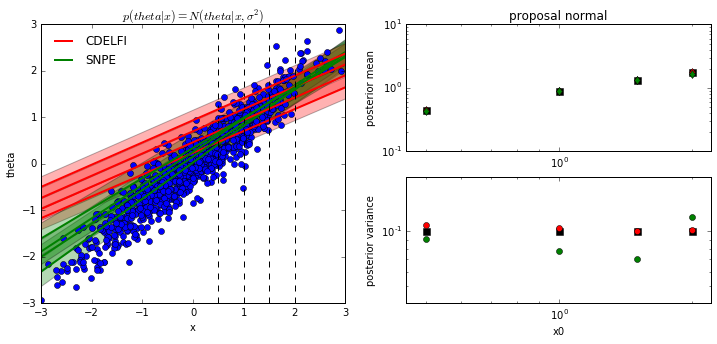

In [9]:
my_fun(df, x0s, 'normal', 'lin', eta2, sig2, N)

## scenario #1b: Student-t proposals for SNPE

- Student-t proposals SNPE to help importance sampling, giving better-quality results overall
- SNPE now **perfectly global** fit of MDN to $p(\theta|x)$ (as targeted by SNPE loss)

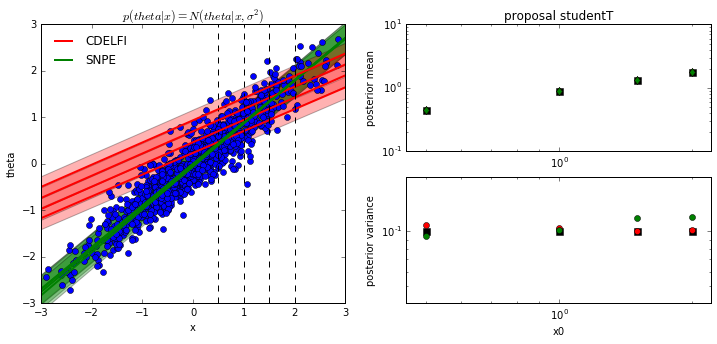

In [10]:
my_fun(df, x0s, 'studentT', 'lin', eta2, sig2, N)

## scenario #2: non-linear toy problem

- still closed-form solution to posterior:  $p(\theta|x) = \mathcal{N}(\theta \ | \ \log(x), \ \gamma^2)$
- MDN now too simple for problem. 

### scenario #2a: Gaussian proposals

- CDELFI: **local** approximations of $p(\theta|x)$, which are **corrected** for analyically. Overall, some clear errors now (model missmatch!)
- SNPE: somewhat **local** fitting of MDN to $p(\theta|x)$, somewhat okayish results

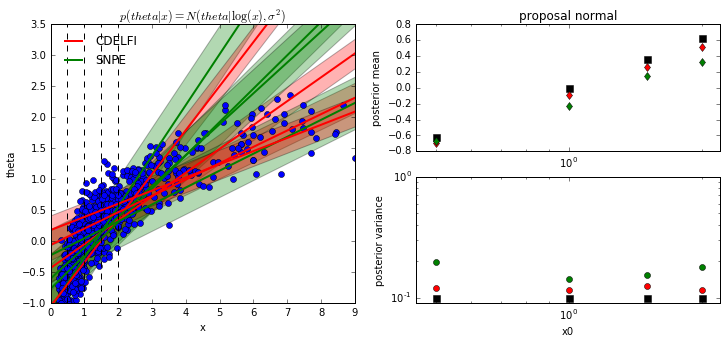

In [5]:
my_fun(df, x0s, 'normal', 'log', eta2, sig2, N)

### scenario #2b: Student-t proposals for SNPE

- SNPE: **almost-perfectly global** fit of MDN to $p(\theta|x)$, here leading to vastly overestimated variance 

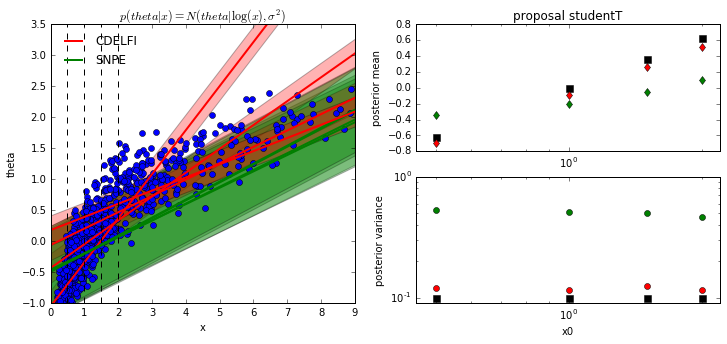

In [6]:
my_fun(df, x0s, 'studentT', 'log', eta2, sig2, N)

## summary of findings

- CDELFI learns local approximations to $p(\theta | x)$ as seen when comparing across different $x_0$. 
- SNPE tends to learn globally, i.e. MDN fits are more similar across different $x_0$. 
- differences in SNPE MDN fits almost vanish when using Student-t proposals. 
- on non-linear problems with simple linear MDNs, global fits can turn out much poorer than local approximations. 


## interpretation / (tentative) conclusion

- SNPE learns globally unless importance sampling breaks down. 
- complex interplay between importance sampling and local vs. global fitting 
- incomplete importance sampling allows local approximations of $p(\theta|x)$, but correction for proposal priors is incomplete ? 


- global fitting of SNPE should be awesome for amortization. 
- questions of model complexity $q_\phi(\theta | x)$ however seemingly more pressing for SNPE than for CDELFI.

# calibration kernels

As shown in Appendix A of Lueckmann et al. (2018), a calibration-kernel $K(x, x_0)$ can be used to manipulate the loss into a local approximation around $x_0$ without changing the target posterior and solution around $x_0$. For $N \to \infty$, the kernel-calibrated loss becomes

$$\mathcal{L}_{K}(\phi) = D_{KL}(p(\theta|x) p_K(x) || q_\phi(\theta|x) p_K(x))$$

For the Gaussian toy case, we can actually compute the kernel $K$ that induces the same marginal $p(x)$ as otherwise the proposal prior $\tilde{p}(\theta)$ would have induced. For $K(x,x_0) = \mathcal{N}(x_K, \sigma_K^2)$, we in the case of a simple Gaussian likelihood $p(x | \theta)$ have that
$$ p_K(x) = \frac{1}{Z_k} \int K(x, x_0) p(\theta) p(x |\theta) d\theta = \mathcal{N}(x | \mu_\epsilon,\sigma_\epsilon^2), $$

i.e. $p_K(x)$ is another Gaussian. Additionally, for proposal priors $\tilde{p}(\theta) = \mathcal{N}(\frac{\eta^2}{\eta^2+\sigma^2}x_0, \eta^2 - \frac{\eta^4}{\eta^2 + \sigma^2})$ we find that 
$$p_K(x) = \tilde{p}(x) = \int \tilde{p}(\theta) p(x|\theta) d\theta$$ 
for $x_K = \frac{\eta^2}{\eta^2 - \xi^2} x_0$, $\sigma_K^2 = \frac{(\sigma^2 + \xi^2)(\sigma^2 + \eta^2)}{\eta^2 - \xi^2}$. Thus for such Kernels $K(x, x_0) \propto \mathcal{N}(x | x_K, \sigma_K^2)$, we have 

$$\mathcal{L}_{K}(\phi) = D_{KL}(p(\theta|x) p_K(x) || q_\phi(\theta|x) p_K(x))
=  D_{KL}(p(\theta|x) \tilde{p}(x) || q_\phi(\theta|x) \tilde{p}(x))$$

i.e. we learn the density $p(\theta|x)$ over the same range of $x$ as CDELFI learns from its loss

$$\tilde{\mathcal{L}}(\phi) = D_{KL}( \tilde{p}(\theta) p(x|\theta) || q_\phi(\theta|x) \tilde{p}(x))$$

with the major difference being that the CDELFI results from $\tilde{\mathcal{L}}(\phi)$ need to be correct for $\tilde{p}(\theta)$ while those from $\mathcal{L}_{K}(\phi)$ do not.

# tbd
- compute calibration kernel effectively equal to proposal prior also for log-gaussian likelihood. 
- compare locality of results between CDELFI and SNPE. 